# Avito: O que é? 

# Importando libs

In [22]:
%matplotlib inline  
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.model_selection import train_test_split

# Carregando o dataset

In [5]:
df_simple = pd.read_csv('train.csv.zip', compression='zip')

## Tratamento dos dados

In [20]:
# transformando descrições nulas em str vazias
df['description'] = df_simple['description'].replace(np.nan, '', regex=True)


In [ ]:

# trocando para que colunas com valores em russo sejam substituidas por valores de 0-N
# acho q isso vai facilitar na hora de acessar essas colunas
# ao inves de tentar pegar pelos diferentes valores de cada uma
def convert_columns_with_russian_values_to_numbers(df, cols):
    transform_dict = {}
    for col in cols:
        cats = pd.Categorical(df[col]).categories
        d = {}
        for i, cat in enumerate(cats):
            d[cat] = f'{i}'
        transform_dict[col] = d
    inverse_transform_dict = {}
    for col, d in transform_dict.items():
        inverse_transform_dict[col] = {v:k for k, v in d.items()}
        
    return df.replace(transform_dict), inverse_transform_dict
# Aplica essa função para category_name e region
df, inverse_transform_dict = convert_columns_with_russian_values_to_numbers(df, ['category_name', 'region'])

# transforma user_type e category_name em diferentes colunas com representações one-hot delas
df = pd.get_dummies(df, columns=['user_type','category_name', ])


In [ ]:
# add deal_prob_class (low, average ou high)

def convert_deal_probability_to_class(value):
    classes = [

    ]
    if value * 100 <= (100 / 3 * 1):
        return 'low'
    elif value * 100 <= (100 / 3 * 2):
        return 'average'
    else:
        return 'high'

df['deal_prob_class'] = df['deal_probability'].apply(convert_deal_probability_to_class)

## Train-test split (com amostra)

In [23]:
# train_frac == 0.34 ~= 510000 ~= total de exemplos no test_csv.zip
def get_train_test_samples(df, seed, train_frac=0.34): 
    train_dfs = []
    test_dfs = []
    for klass in ['low', 'average', 'high']:
        klass_df = df[df['deal_prob_class'] == klass]
        klass_train, klass_test = train_test_split(klass_df,  test_size=(1-train_frac), random_state=seed)
        train_dfs.append(klass_train)
        test_dfs.append(klass_test)
        
    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)
    return train_df, test_df

seed = np.random.RandomState(seed=123654)
train_df, test_df = get_train_test_samples(df, seed, train_frac=0.34)

511163

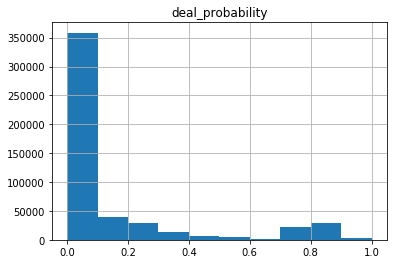

In [25]:
train_df.hist('deal_probability')
train_df.shape[0]

Comparando com o original:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44738a7198>]],
      dtype=object)

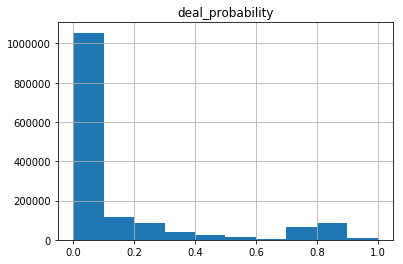

In [26]:
df.hist(column='deal_probability')

## Sobre os dados

* title
* description
* user_type
* price
* category_name
* item_seq_number
* region
* deal_probability


Uma olhada nos dados:

In [4]:
df.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Agrupando pelas categorias

In [8]:
group_category = df_simple.groupby('category_name')
group_category.count().head(3)

,item_id,user_id,region,city,parent_category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
category_name,,,,,,,,,,,,,,,,,
Автомобили,62494,62494,62494,62494,62494,62055,62055,61937,62494,62494,61287,62494,62494,62494,58949,58949,62494
Аквариум,4840,4840,4840,4840,4840,0,0,0,4840,4504,4302,4840,4840,4840,4519,4519,4840
Аудио и видео,27036,27036,27036,27036,27036,26857,0,0,27036,24880,26186,27036,27036,27036,25893,25893,27036


Conferindo comportamento de items com preço 0
grande parte é proximo de 0
E alguns tmb são muito vendidos (vi que tem muitas coisas de troca, ou adoção de animal abandonado por exemplo)

(2369, 18)
(2277, 18)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f931a501588>]],
      dtype=object)

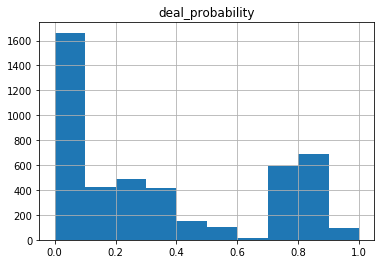

In [6]:
free_price = df[(df['price'] == 0)]
print(free_price[(free_price['deal_probability'] < 0.25)].shape)
print(free_price[(free_price['deal_probability'] >= 0.25)].shape)
free_price.hist(column='deal_probability')

## Visualizando a distribuiçã das probabilidades de venda

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44380074a8>]],
      dtype=object)

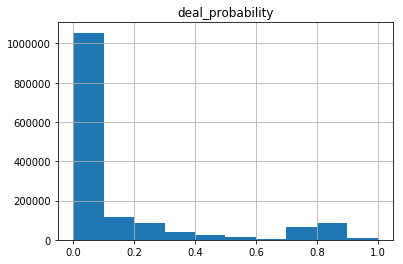

In [10]:
df.hist(column='deal_probability')

# Testando montar um bag of words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def prepare_vectorizer_and_col(df, col_name):
    vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
    corpus = df[col_name]
    col_vectorized = vectorizer.fit_transform(corpus)
    return col_vectorized, vectorizer

    

description_vectorized, vectorizer_description = prepare_vectorizer_and_col(df, 'description')

[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
from sklearn.naive_bayes import MultinomialNB

def get_multinomial_NB(X, y):
    classifier = MultinomialNB()
    classifier.fit(X, y)
    return classifier


In [16]:
model_description_multinomial_nb = get_multinomial_NB(description_vectorized, df['deal_prob_class'])

## testando modelo LinearRegression

In [24]:
from sklearn.linear_model import LinearRegression
clf = BayesianRidge()

# clf.(description_vectorized, df['deal_probability'])
linear_regression = LinearRegression()
linear_regression.fit(description_vectorized, df['deal_probability'])
# clf.predict()


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
import pickle
def save_description_linear_regression_model(pkl_filename, model):
    with open(pkl_filename, 'wb') as f:
        pickle.dump(model, f)
def load_description_linear_regression_model(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        pickle_model = pickle.load(f)
        return pickle_model

In [37]:
save_description_linear_regression_model('description_countvec_lreg_model.pkl', linear_regression)
description_countvec_lreg_model = load_description_linear_regression_model('description_countvec_lreg_model.pkl')

In [ ]:
testv = description_countvec_lreg_model.coef_ == linear_regression.coef_

### Testando o modelo em cima do proprio dataset de treino:

In [53]:
from sklearn.metrics import mean_squared_error
#Bobinho, testando em cima do proprio treino, e ainda assim ficou bem ruim
desc_countvec_lreg_predict = description_countvec_lreg_model.predict(description_vectorized)

mean_squared_error(df['deal_probability'], desc_countvec_lreg_predict)

0.0396135274399414

## Testando usando linear regression + o predict do modelo anterior

primeiro add essa predict do modelo anterior no dataset

In [57]:
df['desc_countvec_lreg_predict'] = desc_countvec_lreg_predict

Agora usar isso e 'user_type, price, category_name, item_seq_number, region' pra 
 fazer uma nova linear regression (só preciso normalizar primeiro e arrumar as colunas que são classes)

#### user_type

In [100]:
# user_types = df['user_type'].value_counts().index
# for user_type in user_types:
#     df = df.drop(f'user_type_{user_type}', 1).head()
#     df[f'user_type_{user_type}'] = np.zeros((df.shape[0], 1))
    


,item_id,user_id,region,city,parent_category_name,param_1,param_2,param_3,title,description,...,category_name_Растения,category_name_Ремонт и строительство,category_name_Собаки,category_name_Спорт и отдых,category_name_Телефоны,category_name_Товары для детей и игрушки,category_name_Товары для животных,category_name_Товары для компьютера,category_name_Фототехника,category_name_Часы и украшения
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",...,0,0,0,0,0,1,0,0,0,0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",...,0,0,0,0,0,0,0,0,0,0
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",...,0,0,0,0,0,0,0,0,0,0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,...,0,0,0,0,0,1,0,0,0,0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,...,0,0,0,0,0,0,0,0,0,0


## testando modelo BayesianRidge

Precisa de uma matriz densa, e nao uma sparse.

In [43]:
# from sklearn.linear_model import BayesianRidge
# clf = BayesianRidge()
# clf.fit(description_vectorized, df['deal_probability'])
# # clf.predict()


In [57]:
# # vectorizer.transform(['Кокон']).toarray().
# print(vectorizer.vocabulary_.get('BLUESKAY'))
# corpus[corpus.str.contains("blueskay")]
# # vectorizer.get_feature_names()[100000]
# df[df['description'] == corpus[33135]]
# vectorizer.transform(None).toarray()


In [59]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model_gaussian_description = gnb.fit(X, ).predict(iris.data)


In [19]:
# df_test = pd.read_csv('test.csv.zip', compression='zip')
df_test.shape[0]

508438

0          low
1          low
4          low
6          low
8          low
9          low
11         low
12         low
13         low
14         low
15         low
16         low
17         low
18         low
19         low
20         low
21         low
22         low
23         low
24         low
25         low
26         low
27         low
28         low
29         low
30         low
32         low
33         low
36         low
37         low
          ... 
1503389    low
1503390    low
1503391    low
1503392    low
1503393    low
1503395    low
1503396    low
1503397    low
1503398    low
1503399    low
1503400    low
1503401    low
1503402    low
1503403    low
1503404    low
1503405    low
1503407    low
1503408    low
1503409    low
1503410    low
1503411    low
1503412    low
1503413    low
1503414    low
1503415    low
1503416    low
1503418    low
1503419    low
1503422    low
1503423    low
Name: deal_prob_class, Length: 1271953, dtype: object